# Numerical expression inference problem: the GEP-RNC algorithm
In this example, we aim to identify a mathematicalfunction $f$ from the given input-ouput data such that the function $f$ can produce the expected ouput given a certain input. This is a typical [symbolic regression](https://en.wikipedia.org/wiki/Symbolic_regression) problem:

> Symbolic regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity.

which is most commonly solved with genetic programming and its variant, gene expression programming (GEP), presented here. 

Before continuing this example, you'd better first go through the two fundamental tutorials listed below to get familiar with GEP and *geppy*:
+ [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html)
+ [Overview of geppy for Gene Expression Programming (GEP)](https://geppy.readthedocs.io/en/latest/overview.html)

The main difference of this problem w.r.t the [Boolean function identification](Boolean_function_identification.ipynb) problem is that generally a mathematical model involves constant coefficients, which is more challenging for both genetic programming (GP) and GEP. The standard way to handle numerical constants in GEP is to add another Dc domain in the genes dedicated to random numerical constant (RNC) evolution, i.e., the GEP-RNC algorithm. Please check 

To check the detailed documentation of each function/class in *geppy*, please refer to [library reference](https://geppy.readthedocs.io/en/latest/#library-reference).

In [1]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

# for reproduction
s = 12
random.seed(s)
np.random.seed(s)

# Synthetic dataset

For this simple task, we first choose a ground truth function $f$ to generate a dataset $D$. Then, 50 input-output exampels are generated randomly.

In [2]:
def f(x):
    """Ground truth function"""
    return -2 * x ** 2 + 21 * x - 84

In [3]:
n_cases = 100
X = np.random.uniform(-10, 10, size=n_cases)   # random numbers in range [-10, 10)
Y = f(X) + np.random.normal(size=n_cases)   # Gaussian noise

# Creating the primitives set
The first step in GEP (or GP as well) is to specify the primitive set, which contains the elementary building blocks to formulate the model. For this problem, we have:
+ function set: the standard arithmetic operators addition (+), subtraction (-), multiplication (*), and division (/).
+ terminal set: only the single input 'x' and random numerical constants (RNC).

NOTE:

- We define a *protected division* to avoid dividing by zero.
- Even there may be multiple RNCs in the model, we only need to call `PrimitiveSet.add_rnc` once.

In [4]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

In [5]:
import operator 

pset = gep.PrimitiveSet('Main', input_names=['x'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_rnc()

# Create the individual and population
Our objective is to **minimize** the MSE (mean squared error) for data fitting.
## Define the indiviudal class, a subclass of *gep.Chromosome*

In [6]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

## Register the individual and population creation operations
In DEAP, it is recommended to register the operations used in evolution into a *toolbox* to make full use of DEAP functionality. The configuration of individuals in this problem is:
+ head length: 7
+ number of genes in each chromosome: 2
+ RNC array length: 5

Generally, more complicated problems require a larger head length and longer chromosomes formed with more genes. **The most important is that we should use the `GeneDc` class for genes to make use of the GEP-RNC algorithm.**

In [7]:
h = 8 # head length
n_genes = 2   # number of genes in a chromosome
r = 8   # length of the RNC array

In [8]:
toolbox = base.Toolbox()
toolbox.register('rnc_gen', random.randint, a=-5, b=5)   # each RNC is random integer within [-5, 5]
# gene_gen binds parameters for GeneDc.__init__, then toolbox.gene_gen() will create a gene
toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h, rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# Define the fitness evaluation function
In DEAP, the single objective optimization problem is just a special case of more general multiobjective ones. Since *geppy* is built on top of DEAP, it conforms to this convention. **Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable.** 

Knowing that, you can understand why the evaluation function must return a tuple value (even if it is a 1-tuple). That's also why we set ``weights=(-1,)`` when creating the ``FitnessMax`` class.

In [9]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, X)))
    return np.mean(np.abs(Y - Yp)),

In [10]:
toolbox.register('evaluate', evaluate)

# Register genetic operators
Compared with GP and other genetic algorithms, GEP has its own set of genetic operators aside from common mutation and crossover. For details, please check the tutorial [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html).

In the following code, the selection operator is ``tools.selTournament`` provided by DEAP, while all other operators are specially designed for GEP in *geppy*.

In [11]:
toolbox.register('select', tools.selTournament, tournsize=5)
# 1. general operators
toolbox.register('mutate', gep.mutate_uniform, pset=pset, ind_pb=0.05)
toolbox.register('invert', gep.invert)
toolbox.register('is_Transpose', gep.is_transpose)
toolbox.register('ris_Transpose', gep.ris_transpose)
toolbox.register('gene_Transpose', gep.gene_transpose)
toolbox.register('crossover_one_point', gep.crossover_one_point)
toolbox.register('crossover_two_point', gep.crossover_two_point)
toolbox.register('crossover_gene', gep.crossover_gene)
# 2. Dc-specific operators
toolbox.register('mutate_dc', gep.mutate_uniform_dc, ind_pb=0.05)
toolbox.register('invert_dc', gep.invert_dc)
toolbox.register('transpose_dc', gep.transpose_dc)
toolbox.register('mutate_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb=0.01)

# Statistics to be inspected
We often need to monitor of progress of an evolutionary program. DEAP offers two classes to handle the boring work of recording statistics. Details are presented in [Computing statistics](http://deap.readthedocs.io/en/master/tutorials/basic/part3.html). In the following, we are intereted in the average/standard deviation/min/max of all the individuals' fitness in each generation.

In [12]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Launch evolution
We make use of *geppy*'s builtin algorithm ``gep_rnc`` here to perform the GEP-RNC evolution. A special class from DEAP, `HallOfFame`, is adopted to store the best individuals ever found. Besides, it should be noted that in GEP [*elitism*](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) is highly recommended because some genetic operators in GEP are destructive and may destroy the best individual we have evolved.

In [13]:
# size of population and number of generations
n_pop = 300
n_gen = 100

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
pop, log = gep.gep_rnc(pop, toolbox, mutation_pb=1, inversion_pb=0.1, is_transposition_pb=0.1, ris_transposition_pb=0.1, 
                          gene_transposition_pb=0.1, crossover_1p_pb=0.3, crossover_2p_pb=0.2, crossover_gene_pb=0.1,
                          dc_mutation_pb=1, dc_inversion_pb=0.1, dc_transposition_pb=0.1, dc_rnc_array_mutation_pb=1,
                            n_generations=n_gen, n_elites=2,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg   	std    	min    	max    
0  	300   	173.51	141.833	62.6792	2431.68
1  	298   	174.106	392.286	62.6792	6919.84
2  	298   	155.742	119.277	61.7432	1846.12
3  	298   	268.001	1326.56	46.3216	20990.1
4  	298   	229.743	458.305	46.3216	4869.73
5  	298   	269.355	805.483	46.3216	11645.7
6  	298   	315.92 	769.945	40.647 	8572.75
7  	298   	331.491	751.294	40.647 	7226.5 
8  	298   	307.603	843.29 	39.7501	9923.25
9  	298   	337.021	565.274	39.7501	5438.28
10 	298   	343.176	791.481	39.7501	8764.6 
11 	298   	530.6  	2610.14	39.0962	42488.6
12 	298   	278.766	532.089	28.6222	4735.88
13 	298   	357.759	845.873	28.6222	8107.37
14 	298   	303.805	742.246	28.6222	6339.69
15 	298   	332.643	982.668	18.183 	7492.11
16 	298   	550.608	6113.02	18.183 	105820 
17 	298   	167.413	428.019	2.17636	6940.81
18 	298   	174.126	409.997	2.17636	6167.06
19 	298   	189.182	572.457	2.17636	7969.52
20 	298   	147.469	211.423	2.17636	2387.1 
21 	298   	159.376	263.619	2.17636	2308.28
22 	298   	15

**Let's check the best individuals ever evolved.**

In [14]:
print(hof[0])

add(
	add(mul(0, protected_div(x, x)), add(mul(x, -5), -4)),
	mul(mul(sub(-5, -3), sub(x, 5)), sub(-5, sub(3, x)))
)


# *[optional]* Post-processing: simplification and visualization
## Symbolic simplification of the final solution
The original solution seems a little complicated, which may contain many redundancies, for example, `protected_div(x, x)` is just 1. We can perform symbolic simplification of the final result by `geppy.simplify` which depends on `sympy` package.

In [15]:
best_ind = hof[2]
symplified_best = gep.simplify(best_ind)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
-2*x**2 + 21*x - 84


## Visualization
If you are interested in the expression tree corresponding to the individual, i.e., the genotype/phenotype system, *geppy* supports tree visualization by the `graph` and the `export_expression_tree` functions:

- `graph` only outputs the nodes and links information to describe the tree topology, with which you can render the tree with tools you like;
- `export_expression_tree` implements tree visualization with data generated by `graph` internally using the `graphviz` package. 

In [16]:
 # we want use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

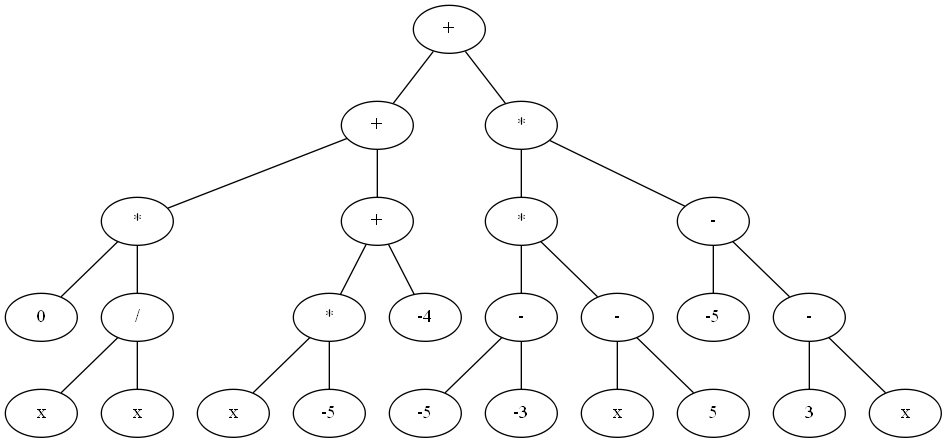

In [17]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png') 

# Discussion
If only integer constants are involved, then the GEP-RNC algorithm is very effective. If the constants are general real numbers, then more advanced techniques like local search may be more suitable.